# Programming Exercise 2: Logistic Regression
(Machine Learning Course)

Bài tập này sẽ hướng dẫn bạn cách cài đặt thuật toán logistic regression bằng python và áp dụng trên hai tập dữ liệu khác nhau.

## Logistic Regression

Trong phần này, bạn sẽ cài đặt mô hình logistic regression để dự đoán liệu một học sinh có được nhận vào học ở trường ĐH không. Dự đoán sẽ dựa trên kết quả của hai kỳ thi trước đó của mỗi học sinh. Dữ liệu về điểm thi và nhãn (được nhận hay không được nhận) có trong file ```ex2data1.txt```.

### Đọc dữ liệu với pandas
Trong phần này, tôi sẽ sử dụng thư viện ```pandas``` để đọc và mô tả dữ liệu.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ex2data1.txt', header=None)

df.head()

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Xem mô tả về dữ liệu với lệnh ```df.describe```.

In [2]:
df.describe()

,0,1,2
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


### Visualizing the data

Trước khi cài đặt một thuật toán học máy nào, bạn nên vẽ đồ thị để khám phá dữ liệu. Đoạn code dưới đây sẽ thực hiện các tác vụ sau:

- Đọc dữ liệu từ file
- Hiển thị 2-D plot thể hiện mối quan hệ giữa 2 điểm thi của các thí sinh.

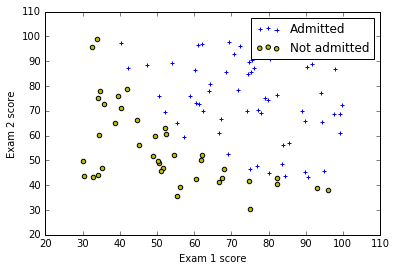

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('ex2data1.txt', delimiter=',', dtype=np.float64)
X = data[:,0:2]
y = data[:,2]

def plot_data(X, y):
    # indexes of admitted and not admitted students
    pos = y == 1
    neg = y == 0
    plt.scatter( X[pos,0], X[pos,1], marker='+', c='b')
    plt.scatter( X[neg,0], X[neg,1], c='y')
    return plt

plt = plot_data(X, y)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend( ('Admitted', 'Not admitted'), loc = 'upper right' )  
plt.show()

Sau khi đọc dữ liệu vào các biến $X$ và $y$, ta cần thêm các "intercept term" vào ma trận $X$ và khởi tạo giá trị ban đầu của $\theta$

In [4]:
m, n = X.shape
print (m, n)

X = np.concatenate( ( np.ones( (m, 1) ), X ), axis=1 )
initial_theta = np.zeros(n + 1)
X.shape

(100, 2)


(100, 3)

### Cài đặt

#### Bài tập "khởi động": cài đặt hàm sigmoid

Trước khi cài đặt hàm cost, nhớ lại rằng logistic regression sử dụng hàm hypothesis sau:

$$h_\theta(x) = g(\theta^Tx)$$

trong đó $g$ là hàm sigmoid. Hàm sigmoid được định nghĩa như sau:

$$g(z)=\frac{1}{1+e^{-z}}$$

Đoạn code sau sẽ cài đặt hàm sigmoid. Đầu vào của hàm sigmoid là giá trị $z$, đầu ra là giá trị của hàm sigmoid $g$. Chú ý cài đặt sao cho hàm sigmoid có thể nhận các kiểu giá trị khác nhau (ma trận, vector hoặc kiểu scalar).

In [5]:
# z can be np.ndarray, np.matrix, or scalar
def sigmoid(z):
    return 1 / ( 1 + np.exp(-z) ) 

Sau khi cài đặt hàm sigmoid, chúng ta sẽ thử một vài giá trị của hàm $sigmoid(z)$. Khi $z$ nhận giá trị dương rất lớn, hàm sigmoid sẽ gần với giá trị 1. Khi $z$ là các số âm rất lớn, hàm sigmoid sẽ dần tới 0. Giá trị $sigmoid(0)$ sẽ nhận giá trị $0.5$. Chúng ta cũng sẽ thử với kiểu vector và matrix.

In [6]:
# to remove overflow warnings
np.seterr(over='ignore')
for z in [10000, -10000, 0]:
    print 'sigmoid(%.1f) = %1.1f' % (z, sigmoid(z))

print sigmoid(np.array([1, 0, 0.5, -1]))
print sigmoid(np.array( [[1, 0], [0.5, -1]]))

sigmoid(10000.0) = 1.0
sigmoid(-10000.0) = 0.0
sigmoid(0.0) = 0.5
[ 0.73105858  0.5         0.62245933  0.26894142]
[[ 0.73105858  0.5       ]
 [ 0.62245933  0.26894142]]


#### Cài đặt cost function và gradient

Trong phần này, chúng ta sẽ cài đặt cost function và hàm gradient cho logistic regression.

Như chúng ta đã được học trong bài giảng về logistic regression, cost function trong logistic regression được định nghĩa như sau:
$$J(\theta) =\frac{1}{m}\sum_{i=1}^{m}\left[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))\right]$$

và gradient của cost function là 1 vector có cùng độ dài với $\theta$ trong đó phần tử $j^{th}$ (với $j=0,1,\cdots,n$ được định nghĩa như sau:

$$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m}\sum_{i=1}^{m}\left(h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}$$

Chú ý rằng, công thức gradient trên giống gradient trong TH linear regression, nhưng định nghĩa hàm $h_\theta(x)$ trong hai trường hợp khác nhau.

Hàm ```cost_function``` với đầu vào là vector $\theta$, ma trận $X$ và $y$ sẽ trả về cost function và gradient.

In [7]:
# X.shape m x n
# theta.shape n x 1
# y.shape m x 1
def cost_function(theta, X, y):
    m = y.shape[0]
    J = 0
    hx = sigmoid( np.dot(X, theta) ) # hx.shape m x 1
    J = np.sum( -y * np.log(hx) - (1-y) * np.log(1-hx) )/m
    return J

# gradient function
def gradient(theta, X, y):
    m = y.shape[0]
    grad_ = np.zeros( theta.shape[0] )
    hx = sigmoid( np.dot(X, theta) ) # hx.shape m x 1
    grad_ = np.dot(X.T, hx - y) / m
    return grad_

Sau khi định nghĩa hàm ```cost_function```, ta sẽ tính giá trị của cost function với giá trị khởi tạo ban đầu của $\theta$. Kết quả thu được của cost khoảng $0.693$.

In [8]:
cost = cost_function(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print X.shape
print y.shape
print initial_theta
print 'Cost at initial theta (zeros): %f' % cost
print 'Gradient at initial theta (zeros):\n%s' % grad

(100, 3)
(100,)
[ 0.  0.  0.]
Cost at initial theta (zeros): 0.693147
Gradient at initial theta (zeros):
[ -0.1        -12.00921659 -11.26284221]


#### Học tham số sử dụng hàm fmin, fmin_bfgs

Trong bài tập trước (phần linear regression), chúng ta đã cài đặt thuật toán gradient descent để học tham số $\theta$. Trong phần này, chúng ta sẽ sử dụng hàm ```fmin_bfgs``` trong thư viện [scipy.optimize](http://docs.scipy.org/doc/scipy-0.10.0/reference/generated/scipy.optimize.fmin_bfgs.html#scipy.optimize.fmin_bfgs) để tìm $\theta$.

*Cập nhật*: Do chưa thạo cách dùng hàm ```fmin_bfgs``` nên mình sẽ dùng tạm hàm ```fmin``` (Xem thêm tại [fmin](https://docs.scipy.org/doc/scipy-0.8.x/reference/generated/scipy.optimize.fmin.html#scipy.optimize.fmin)). Thuật toán cài đặt trong ```fmin``` hội tụ chậm hơn so với ```fmin_bfgs```.

In [9]:
from scipy.optimize import fmin_bfgs, fmin
theta = fmin( cost_function, initial_theta, args=(X,y) )

print 'Cost at theta (found by fmin): %f' % cost_function(theta, X, y)
print 'theta: %s' % theta

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
Cost at theta (found by fmin): 0.203498
theta: [-25.16130062   0.20623142   0.20147143]


####  Đánh giá logistic regression

Sau khi học các tham số $\theta$, chúng ta có thể sử dụng mô hình đã học để tính xác suất một sinh viên trúng tuyển. Ví dụ: một sinh viên với điểm thi 1 là 45, điểm thi 2 là 85 có xác suất trúng tuyển là 0.776. Đoạn code sau sẽ thực hiện công việc đó:

In [10]:
st = np.array( [1, 45, 85] )
prob = sigmoid( np.dot(theta, st) )
print 'Xác suất sinh viên (với điểm số 45, 85) trúng tuyển: %f' % prob

Xác suất sinh viên (với điểm số 45, 85) trúng tuyển: 0.776292


Một cách khác để đánh giá chất lượng của các số học từ dữ liệu là đánh giá độ chính xác của dự đoán trên dữ liệu huấn luyện sử dụng các tham số này. Để thực hiện công việc này, trước tiên, chúng ta sẽ cài đặt hàm ```predict``` -- hàm trả về các giá trị 1 và 0 với dữ liệu và tham số $\theta$.

In [11]:
# theta.shape = (n,)
# X.shape = (m, n)
# should return an array with shape (m,)
def predict(theta, X):
    hx = np.dot(X, theta)
    hx[hx >= 0.5] = 1
    hx[hx < 0.5] = 0
    
    return hx

Chúng ta sẽ sử dụng hàm ```predict``` để tính độ chính xác trên dữ liệu huấn luyện.

In [12]:
p = predict(theta, X)
print 'Train accuracy: %s' % ( 100 * (p == y).mean() )

Train accuracy: 89.0


#### Vẽ decision boundary

Chúng ta sẽ sử dụng giá trị $\theta$ đã học được từ dữ liệu để vẽ decision boundary. Không gian dữ liệu huấn luyện là không gian 2D nên decision boundary là một đường thẳng. Chú ý rằng các điểm trên đường thẳng sẽ thoả mãn phương trình sau đây:
$$\theta^Tx=0$$

Với không gian 2D, phương trình trên sẽ được diễn giải thành:
$$\theta_0 + \theta_1x_1 + \theta_2x_2=0$$

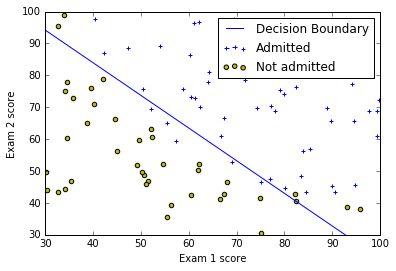

In [13]:
plot_data(X[:,1:3], y)
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plot_x = np.arange(np.min(X[:,1])-2, np.max(X[:,1])+2)
plot_y = -(theta[0] + theta[1] * plot_x)/theta[2]
plt.plot(plot_x, plot_y, label='Decision Boundary')
plt.axis([30,100,30,100])
plt.legend( ['Decision Boundary', 'Admitted', 'Not admitted'], 
            loc = 'upper right' ) 
plt.show()

## Regularized Logistic Regression

Trong phần này, chúng ta sẽ thao tác trên file dữ liệu ```ex2data2.txt```. Dữ liệu bao gồm 2 kết quả kiểm tra chất lượng của một con chip và nhãn (1 hoặc 0) thể hiện con chip đủ tiêu chuẩn chất lượng hay không.

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ex2data2.txt', header=None)

df.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### Visualizing the data
Tương tự như bài tập trước, công việc đầu tiên là khám phá dữ liệu thông qua data visualization.

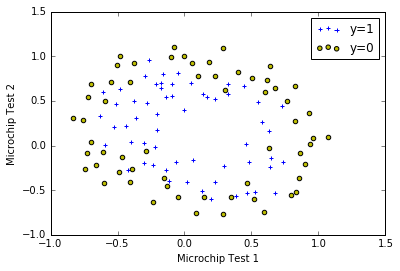

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('ex2data2.txt', delimiter=',', dtype=np.float64)
X = data[:,0:2]
y = data[:,2]

plt = plot_data(X, y)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(('y=1', 'y=0'), loc='best')
plt.show()

Hình vẽ trên cho thấy, dữ liệu đã cho không thể phân chia thành *positive* và *negative* chỉ với đường thẳng. Vì thế áp dụng logistic regression một cách đơn giản trên dữ liệu sẽ không có độ chính xác cao vì logistic regression chỉ có có thể tìm được **decision boundary** dạng tuyến tính.

### Feature mapping

Một cách để *fit* dữ liệu tốt hơn là tạo thêm các đặc trưng cho mỗi điểm dữ liệu. Trong hàm dưới đây, chúng ta sẽ ánh xạ các dữ liệu thành các hạng tử dạng đa thức của $x_1$ và $x_2$ cho đến bậc 6.

$$\text{mapFeature}(x)=\left[\begin{array}{c}
1\\
x_1\\
x_2\\
x_1^2\\
x_1x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1x_2^5\\
x_2^6\\
\end{array}\right]$$

Với phép ánh xạ đặc trưng, vector gồm 2 đặc trưng sẽ được biến đổi thành vector 28 chiều. Logistic regression huấn luyện với dữ liệu nhiều chiều hơn sẽ có **decision boundary** không tuyến tính khi vẽ trên đồ thị 2 chiều.

Một vấn đề khi huấn luyện mô hình logistic regression trên dữ liệu nhiều chiều là mô hình thu được có khả năng *overfitting* với dữ liệu huấn luyện. Trong các phần sắp tới, chúng ta sẽ cài đặt **regularized logistic regression** trên dữ liệu và sẽ cùng khảo sát liệu **regularization** có thể giúp chúng ta tránh *overfitting* như thế nào.

In [16]:
# X1 and X2 are two feature columns
# Return a new matrix with shapes (m, 28)
def map_feature(X1, X2):
    degree = 6
    out = np.ones( (X1.shape[0],1), dtype=np.float64 )
    for i in xrange(1, degree+1):
        for j in xrange(0,i+1):
            col = (X1 ** (i-j)) * (X2 ** j)
            out = np.concatenate( (out, col), axis=1 )           
    return out

Sử dụng hàm ```map_feature``` để sinh dữ liệu với các features bổ sung.

In [17]:
print X[0:2]
X = map_feature( X[:,[0]], X[:,[1]] )
print X.shape
print X[0:2]

[[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]]
(118, 28)
[[  1.00000000e+00   5.12670000e-02   6.99560000e-01   2.62830529e-03
    3.58643425e-02   4.89384194e-01   1.34745327e-04   1.83865725e-03
    2.50892595e-02   3.42353606e-01   6.90798869e-06   9.42624411e-05
    1.28625106e-03   1.75514423e-02   2.39496889e-01   3.54151856e-07
    4.83255257e-06   6.59422333e-05   8.99809795e-04   1.22782870e-02
    1.67542444e-01   1.81563032e-08   2.47750473e-07   3.38066048e-06
    4.61305487e-05   6.29470940e-04   8.58939846e-03   1.17205992e-01]
 [  1.00000000e+00  -9.27420000e-02   6.84940000e-01   8.60107856e-03
   -6.35227055e-02   4.69142804e-01  -7.97681228e-04   5.89122275e-03
   -4.35092419e-02   3.21334672e-01   7.39785525e-05  -5.46363780e-04
    4.03513411e-03  -2.98012201e-02   2.20094970e-01  -6.86091891e-06
    5.06708697e-05  -3.74226408e-04   2.76382476e-03  -2.04120477e-02
    1.50751849e-01   6.36295342e-07  -4.69931780e-06   3.47065055e-05
   -2.56322636e-04   1.89305413e

Thử kiểm tra với một vài giá trị scalar.

In [18]:
print map_feature(np.array([[0.051267], [-0.092742]]), 
                  np.array([[0.69956], [0.68494] ]) )

[[  1.00000000e+00   5.12670000e-02   6.99560000e-01   2.62830529e-03
    3.58643425e-02   4.89384194e-01   1.34745327e-04   1.83865725e-03
    2.50892595e-02   3.42353606e-01   6.90798869e-06   9.42624411e-05
    1.28625106e-03   1.75514423e-02   2.39496889e-01   3.54151856e-07
    4.83255257e-06   6.59422333e-05   8.99809795e-04   1.22782870e-02
    1.67542444e-01   1.81563032e-08   2.47750473e-07   3.38066048e-06
    4.61305487e-05   6.29470940e-04   8.58939846e-03   1.17205992e-01]
 [  1.00000000e+00  -9.27420000e-02   6.84940000e-01   8.60107856e-03
   -6.35227055e-02   4.69142804e-01  -7.97681228e-04   5.89122275e-03
   -4.35092419e-02   3.21334672e-01   7.39785525e-05  -5.46363780e-04
    4.03513411e-03  -2.98012201e-02   2.20094970e-01  -6.86091891e-06
    5.06708697e-05  -3.74226408e-04   2.76382476e-03  -2.04120477e-02
    1.50751849e-01   6.36295342e-07  -4.69931780e-06   3.47065055e-05
   -2.56322636e-04   1.89305413e-03  -1.39810280e-02   1.03255971e-01]]


Sau khi map features, chúng ta sẽ khởi tạo các giá trị ban đầu trước khi học các tham số từ dữ liệu.

In [19]:
initial_theta = np.zeros( X.shape[1] )
_lambda = 1 # tham số lambda cho regularized logistic regression

### Cost function và gradient
Chúng ta sẽ cài đặt hàm tính cost function và gradient cho **regularized logistic regression**. Chú ý rằng, hàm cost function cho phiên bản regularization có công thức như sau:
$$J(\theta) =\frac{1}{m}\sum_{i=1}^{m}\left[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))\right] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2$$

Chú ý rằng, chúng ta sẽ không áp dụng regularization cho tham số $\theta_0$. Vì thế, gradient cho cost functon là một vector trong đó phần tử thứ $j^{th}$ được định nghĩa như sau:


$$\frac{\partial J(\theta)}{\partial \theta_0}=\frac{1}{m}\sum_{i=1}^{m}\left(h_\theta(x^{(i)}) - y{(i)}\right)x_j^{(i)} \text{   với   } j=0$$

$$\frac{\partial J(\theta)}{\partial \theta_j}=\left(\frac{1}{m}\sum_{i=1}^{m}\left(h_\theta(x^{(i)}) - y{(i)}\right)x_j^{(i)}\right) + \frac{\lambda}{m}\theta_j \text{    với    } j \geq 1$$

In [20]:
def cost_function_reg(theta, X, y, _lambda):
    m = y.shape[0]
    J = 0
    hx = sigmoid( np.dot(X, theta) ) # hx.shape m x 1
    J = np.sum( -y * np.log(hx) - (1-y) * np.log(1-hx) )/m
    J += _lambda * (theta[1:] ** 2).sum()/(2*m)
    return J

def gradient_reg(theta, X, y, _lambda):
    m = y.shape[0]
    grad_ = np.zeros( theta.shape[0] )
    hx = sigmoid( np.dot(X, theta) ) # hx.shape m x 1
    grad_ = np.dot(X.T, hx - y) / m
    temp = np.array(theta)
    temp[0] = 0
    grad_ += _lambda * temp / m
    return grad_

Tính giá trị cost và gradient với các giá trị ban đầu của $\theta$ (gồm các giá trị zeros).

In [21]:
cost = cost_function_reg(initial_theta, X, y, _lambda)
grad = gradient_reg(initial_theta, X, y, _lambda)
print 'Cost at initial theta (zeros): %f\n' % cost
grad

Cost at initial theta (zeros): 0.693147



array([  8.47457627e-03,   1.87880932e-02,   7.77711864e-05,
         5.03446395e-02,   1.15013308e-02,   3.76648474e-02,
         1.83559872e-02,   7.32393391e-03,   8.19244468e-03,
         2.34764889e-02,   3.93486234e-02,   2.23923907e-03,
         1.28600503e-02,   3.09593720e-03,   3.93028171e-02,
         1.99707467e-02,   4.32983232e-03,   3.38643902e-03,
         5.83822078e-03,   4.47629067e-03,   3.10079849e-02,
         3.10312442e-02,   1.09740238e-03,   6.31570797e-03,
         4.08503006e-04,   7.26504316e-03,   1.37646175e-03,
         3.87936363e-02])

#### Học tham số với thuật toán gradient descent
Chúng ta sẽ thử dụng thuật toán gradient descent để so sánh tham số $\theta$ học được với hàm ```fmin_bfgs``` trong thư viện ```scipy```.

In [22]:
# alpha là learning rate
# num_iters là số vòng lặp
def gradient_descent(X, y, _lambda, alpha, num_iters):
    m = y.shape[0]
    n = X.shape[1]
    theta = np.zeros( n );

    for iter in xrange(num_iters):
        # Compute the vector delta
        grads = gradient_reg(theta, X, y, _lambda)
        theta = theta - alpha * grads

    return theta

theta = gradient_descent(X, y, _lambda, 0.01, 150000)
print 'Cost at theta (found by gradient descent): %f' % cost_function_reg(theta, X, y, _lambda)
print 'theta:'
print theta

Cost at theta (found by gradient descent): 0.529003
theta:
[ 1.27273937  0.62527175  1.18108857 -2.01996044 -0.91742344 -1.43166396
  0.12400647 -0.36553441 -0.35723984 -0.17513025 -1.45815667 -0.05098937
 -0.6155553  -0.27470625 -1.19281661 -0.24218816 -0.20600615 -0.04473108
 -0.2777845  -0.29537813 -0.45635762 -1.04320272  0.02777151 -0.29243149
  0.01556661 -0.32737968 -0.1438869  -0.9246529 ]


Sau khi học tham số $\theta$ từ dữ liệu, code sau đây sẽ tính độ chính xác của dự đoán trên dữ liệu training với mô hình đã học.

In [23]:
p = predict(theta, X)
print('Train accuracy (with gradient descent): %s' 
      % ( 100 * (p == y).mean() ))

Train accuracy (with gradient descent): 79.6610169492


#### Học tham số với fmin, fmin_bfgs
Cài đặt tương tự như phần trước, trước hết chúng ta sẽ dùng hàm ```fmin``` để học $\theta$.

In [24]:
from scipy.optimize import fmin_bfgs, fmin
theta = fmin_bfgs(cost_function_reg, initial_theta,
                  fprime=gradient_reg, args=(X,y,_lambda),
                  maxiter=400)

print('Cost at theta (found by fmin): %f' % 
              cost_function_reg(theta, X, y, _lambda))
print 'theta: %s' % theta

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Cost at theta (found by fmin): 0.529003
theta: [ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119]


In [25]:
p = predict(theta, X)
print('Train accuracy (with fmin_bfgs): %s' % 
      ( 100 * (p == y).mean() ))

Train accuracy (with fmin_bfgs): 79.6610169492


Độ chính xác thu được ở trên khác với kết quả thu được với Octave code của course Machine Learning (83.050847). **Tôi chưa thực sự biết rõ lý do vì sao**.

### Vẽ decision boundary

Chúng ta sẽ sử dụng giá trị $\theta$ học được để vẽ "decision boundary" trên dữ liệu training. **Decision boundary** được hiểu là một mặt phẳng chia dữ liệu thành các lớp khác nhau.

Tôi tham khảo code vẽ decision boundary tại [đây](http://aimotion.blogspot.jp/2011/11/machine-learning-with-python-logistic.html)

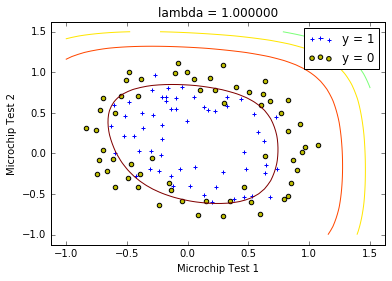

In [26]:
plot_data(X[:,1:3],y)

def plot_decision_boundary(theta, X, y):
    # Plot Boundary
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros( shape = ( len(u), len(v) ) )
    # Evaluate
    for i in range( u.shape[0] ):
        for j in range( v.shape[0] ):
            _x = map_feature( np.array( [[u[i]]] ), np.array( [[v[j]]] ) )
            z[i,j] = np.dot(_x, theta)
    z = z.T
    plt.contour(u, v, z)           

plot_decision_boundary(theta, X, y)
plt.title('lambda = %f' % _lambda)
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0', 'Decision boundary'], loc='best')
plt.show()

### Thử nghiệm các tham số regularization khác nhau

Trong phần này, chúng ta sẽ thử tìm hiểu cách phương pháp regularization tránh overfitting.

Chúng ta sẽ vẽ decision boundary với các giá trị $\lambda$ khác nhau và quan sát sự thay đổi của decision boundary. Với giá trị $\lambda$ rất nhỏ, classifier có thể dự đoán đúng phần lớn các example trong dữ liệu huấn luyện. TH đó được gọi là *overfitting*. Ngược lại khi giá trị $\lambda$ rất lớn, classifier sẽ không *fit* dữ liệu không đủ tốt. TH đó được gọi là *underfitting*.


Optimization terminated successfully.
         Current function value: 0.224569
         Iterations: 546
         Function evaluations: 547
         Gradient evaluations: 547
Train accuracy (with fmin_bfgs): 88.9830508475


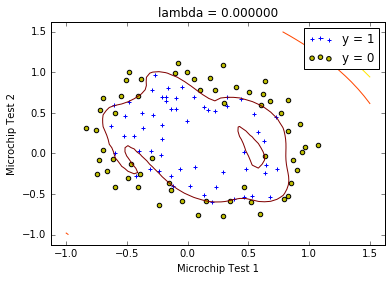

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
Train accuracy (with fmin_bfgs): 79.6610169492


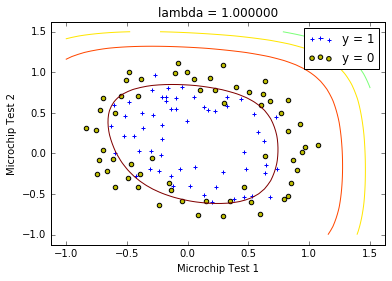

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Train accuracy (with fmin_bfgs): 50.8474576271


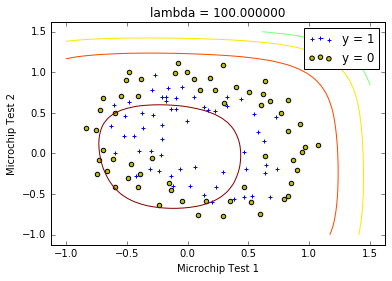

In [27]:
from scipy.optimize import fmin_bfgs, fmin
for l in [0, 1, 100]:
    theta = fmin_bfgs(cost_function_reg, initial_theta,
                  fprime=gradient_reg, args=(X,y, l),
                  maxiter=1000)
    p = predict(theta, X)
    print('Train accuracy (with fmin_bfgs): %s' % 
          ( 100 * (p == y).mean() ))
    plot_data(X[:,1:3],y)
    plot_decision_boundary(theta, X, y)
    plt.title('lambda = %f' % l)
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend(['y = 1', 'y = 0', 'Decision boundary'], loc='best')
    plt.show()